# Train ETA with Machine Learning

A modo de comparación y prueba, realizaremos un entrenamiento de un destino cualquiera (nv-cs) para predecir el tiempo restante o el tiempo de arribo ETA, utiliznado algun modelo de ML.

Si ya realizó el entrenamiento y solo desea levantar el endpoint, hay 2 opciones:
1. Crear modelos mediante la libreria propia de XGB
2. Crear modelos mediante Jobs y librerias de AWS de XGB
3. Deploy de modelos

In [1]:
!pip install xgboost==1.2
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

  Using cached xgboost-1.2.0-py3-none-manylinux2010_x86_64.whl (148.9 MB)


In [3]:
import sagemaker
print(xgb.__version__)
print(sagemaker.__version__)

1.2.0
2.45.0


In [10]:
def plot_ETA(df,eta, error,od, subplot=True,time_step=15):
    
    plt.figure(1,figsize=(25, 10))
    plt.subplot(1, 2, 1)
    plt.title("Real and Predicted ETA.")
    plt.plot(df.loc[:,['distance_m']]/1000, eta/3600, lw=2, label='xgb')
    plt.plot(df.loc[:,['distance_m']]/1000, df['ETA']/3600, lw=2, label='real')
    plt.ylabel('ETA [hr]')
    plt.xlabel('distance [km]')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.legend()
    plt.grid(True)
    if subplot == True:
        plt.subplot(1, 2, 2)
        plt.title("diferencia ETA real vs simulado. OD = "+od)
        plt.plot(df['distance_m']/1000, abs(error/60), color='r', label='dIF ETA xgb')
        plt.xlabel("Distancia Recorrida [km]",fontsize=15)
        plt.ylabel("diferencia ETA [min]",fontsize=15)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)
        plt.legend()
    plt.show()

In [52]:
ods = ['CS-NV','CS-SA','PA-CS','SDC-SA','TO-CS','TO-SA']
folder = '/root/eta-retorno/csv_to_train/'
od = ods[5]
filename = 'dynamics-'+od+'-20200101-20210630.csv'
print(filename)
df = pd.read_csv(folder+filename)
df

dynamics-TO-SA-20200101-20210630.csv


Id   time_s  distance_m  hour      lat      lon  delta_t  \
0           22      0.0         0.0     6 -22.0942 -70.2059      0.0   
1           22      3.0         9.0     6 -22.0942 -70.2060      3.0   
2           22     15.0        56.0     6 -22.0945 -70.2064     12.0   
3           22     17.0        65.0     6 -22.0945 -70.2063      2.0   
4           22     63.0       208.0     6 -22.0954 -70.2053     46.0   
...        ...      ...         ...   ...      ...      ...      ...   
2189894  56328  22802.0    368707.0    13 -23.5953 -68.4644     60.0   
2189895  56328  22862.0    369616.0    13 -23.5912 -68.4566     60.0   
2189896  56328  22922.0    370588.0    13 -23.5869 -68.4484     60.0   
2189897  56328  22981.0    371561.0    13 -23.5826 -68.4401     59.0   
2189898  56328  23042.0    372533.0    13 -23.5782 -68.4318     61.0   

            delta_m      ETA  
0          0.000000  21485.0  
1          8.537108  21482.0  
2         47.042352  21470.0  
3          9.333955  21468.0  
4        142.878840  21422.0  
...             ...      ...  
2189894  835.693865    240.0  
2189895  908.772207    180.0  
2189896  972.571135    120.0  
2189897  973.262001     61.0  
2189898  971.301437      0.0  

[2189899 rows x 9 columns]

### Se pararemos el dataset a mano

In [53]:
# 20 % test y 80 train
ids = df.Id.unique()
cut = int(len(ids)*0.8)
print(cut)

df_train = df.loc[df['Id'].isin(ids[:cut])]
df_test = df.loc[df['Id'].isin(ids[cut:])]

feature = ['time_s','distance_m','hour','lat','lon']
target = ['ETA']
x_train = df_train.loc[:,['time_s','distance_m','hour','lat','lon']]
x_test = df_test.loc[:,['Id','time_s','distance_m','hour','lat','lon']] 
y_train = df_train.loc[:,['ETA']]
y_test = df_test.loc[:,['Id','ETA']]

2737


### Creamos y Entrenamos nuestro modelo

In [54]:
ETA = xgb.XGBRegressor(random_state = 0,tree_method='exact',gamma=1,eta=0.3, max_depth=4)
ETA.fit(x_train, y_train)
print('R^2 del modelo: ',ETA.score(x_test.loc[:,feature], y_test.loc[:,target]))

R^2 del modelo:  0.9537311431845665


In [55]:
y_test = y_test.drop_duplicates()
x_test = x_test.drop_duplicates()

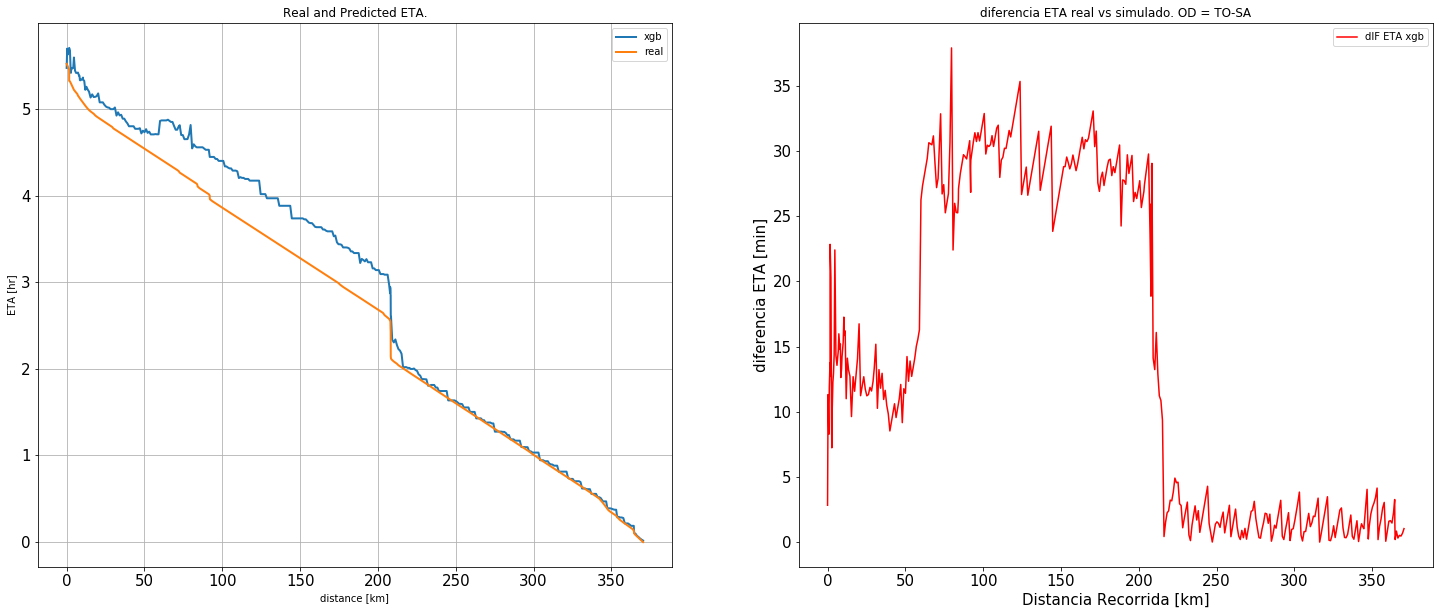

In [56]:
dispatchs = x_test.Id.unique() 
dispatch  = dispatchs[4]
travel = x_test[x_test['Id']==dispatch]
travel = travel.assign(ETA = y_test[y_test['Id']==dispatch].ETA)
travel = travel.assign(predict_eta = ETA.predict(travel.loc[:,feature]))
travel = travel.assign(error = travel.ETA - travel.predict_eta )
travel[travel['time_s']==0]
plot_ETA(travel,travel.predict_eta, travel.error, subplot=True,time_step=15,od=od)

## Guardar y enviar a S3 el modelo

In [57]:
model_file_name = 'eta-retorno-dynamics-xgb-'+od+'-v1'
model_file_output = model_file_name + '.tar.gz' 
path_to_save = './models/'
total_path = path_to_save + model_file_name
total_path_to_save = path_to_save + model_file_output
ETA._Booster.save_model(total_path)

In [58]:
!tar czvf $total_path_to_save $total_path

./models/eta-retorno-dynamics-xgb-TO-SA-v1


In [59]:
# Define IAM role
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
import os


bucket = 'migtra.ai.dev'
local_path = '/root/eta-retorno/models'
name_in_s3 = 'models-eta-retorno/dynamics-models/eta-dynamics-'+od+'xgb-v1.tar.gz'
print(os.path.join(local_path, 'eta-retorno-dinamycs-xgb-'+od+'-v1.tar.gz'))

s3 = boto3.resource('s3')
s3.meta.client.upload_file(os.path.join(local_path, 'eta-retorno-dynamics-xgb-'+od+'-v1.tar.gz'), bucket, name_in_s3)

/root/eta-retorno/models/eta-retorno-dinamycs-xgb-TO-SA-v1.tar.gz


### Guardamos el modelo en versión picle

In [60]:
#!pip install joblib
import joblib

joblib.dump(ETA, '/root/eta-retorno/models/eta-retorno-dynamics-xgb-'+od+'-v1.pkl')

['/root/eta-retorno/models/eta-retorno-dynamics-xgb-TO-SA-v1.pkl']

---

# Entrenar mediante Jobs de AWS

__Para realizar un training job en sagemaker este asume que la variable objetivo se encuentra en la primera columna.__

In [2]:
!pip install sagemaker==2.15
import pandas as pd
import numpy as np

  Using cached sagemaker-2.15.0-py2.py3-none-any.whl
  Using cached smdebug_rulesconfig-0.1.5-py2.py3-none-any.whl (6.2 kB)
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.33.0
    Uninstalling sagemaker-2.33.0:
      Successfully uninstalled sagemaker-2.33.0
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


## Preparación para subir a S3

##  Set Parameter para xgb 

In [23]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.xgboost.estimator import XGBoost
import boto3


sagemaker_session = sagemaker.Session()
role = get_execution_role()

BUCKET = 'migtra.ai.dev'

# This is references the AWS managed XGBoost container
XGBOOST_IMAGE = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='1.0-1')

DATA_PREFIX = 'models-eta-retorno'
MULTI_MODEL_ARTIFACTS = 'multi_model_artifacts'

TRAIN_INSTANCE_TYPE = 'ml.m5.2xlarge'
ENDPOINT_INSTANCE_TYPE = 'ml.m4.xlarge'

ENDPOINT_NAME = 'mm-xgboost-eta-retorno-v1'

MODEL_NAME = ENDPOINT_NAME

In [24]:
sagemaker.__version__

'2.15.0'

__es importante dejar estos parámetros definidos así, de otra manera esto no funciona por problemas de compatibilidad__

In [37]:
import os

def launch_training_job(od, nomultimodel=False, n=1, upload=True, path=folder):
    location = od.upper()

    if upload == True:
        # upload  data set 
        local_data_path = path+'train-s3-'+od+'-xgb-dynamics-eta-retorno-v1.csv'
        print('local path', local_data_path)
        boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(DATA_PREFIX, 'data_train/train-eta-retorno-'+od+'-v1.csv')).upload_file(local_data_path)
        print(f'Training data uploaded for ', od)

    _job = 'xgb-{}'.format(location)
    full_output_prefix = f'{DATA_PREFIX}/model_artifacts/'+location
    s3_output_path = f's3://{BUCKET}/{full_output_prefix}'
    print('s3 output path ', s3_output_path)


    xgb = sagemaker.estimator.Estimator(XGBOOST_IMAGE, role, 
                                        train_instance_count=n, 
                                        train_instance_type=TRAIN_INSTANCE_TYPE,
                                        output_path=s3_output_path, 
                                        base_job_name=_job,
                                        sagemaker_session=sagemaker_session)
    xgb.set_hyperparameters(max_depth=4, eta=0.3, gamma=1, subsample=0.9, min_child_weight=6, silent=0, 
                            early_stopping_rounds=5, objective='reg:linear', num_round=25) 
      
    
    path_s3 = 's3://'+os.path.join(BUCKET,DATA_PREFIX, 'data_train/train-eta-retorno-'+od+'-v1.csv')
    print('step 2 : path s3 ', path_s3)
    train_input = sagemaker.session.s3_input(s3_data=path_s3, 
                                             content_type='csv')
    
#     val_input   = sagemaker.session.s3_input(s3_data=inputs+'/val', 
#                                      distribution=DISTRIBUTION_MODE, content_type='csv')
         
    remote_inputs = {'train': train_input}
    xgb.fit(remote_inputs,wait = nomultimodel) 
    return xgb

In [40]:
import time
def wait_for_training_job_to_complete(estimator):
    job = estimator.latest_training_job.job_name
    print(f'Waiting for job: {job}')
    status = estimator.latest_training_job.describe()['TrainingJobStatus']
    while status == 'InProgress':
        time.sleep(45)
        status = estimator.latest_training_job.describe()['TrainingJobStatus']
        if status == 'InProgress':
            print(f'{job} job status: {status}')
    print(f'DONE. Status for {job} is {status}\n') 

# Automatización Entrenamiento multimodelos

Esta automatización compete subir los csv en la estructura correcta a un bucket en s3 y de esa forma crear un training job con ese csv para el xgb

In [39]:
localidades = ['CS-NV','CS-SA','PA-CS','SDC-SA','TO-CS','TO-SA']
orden = ['ETA','time_s','distance_m','hour','lat','lon']
folder = '/root/eta-retorno/csv_to_train/'
estimadores = []
for i in localidades:
    filename = 'dynamics-'+i+'-20200101-20210630.csv'
    df = pd.read_csv(folder+filename)
    df = df.loc[:,orden]
    df.to_csv(folder+'train-s3-'+i+'-xgb-dynamics-eta-retorno-v1.csv',index=False)
    print('save file '+folder+'train-s3-'+i+'-xgb-dynamics-eta-retorno-v1.csv')
    estimador = launch_training_job(i,nomultimodel=False,n=2,upload = True,path=folder)
    estimadores.append(estimador)

save file /root/eta-retorno/csv_to_train/train-s3-CS-NV-xgb-dynamics-eta-retorno-v1.csv
local path /root/eta-retorno/csv_to_train/train-s3-CS-NV-xgb-dynamics-eta-retorno-v1.csv
Training data uploaded for  CS-NV
s3 output path  s3://migtra.ai.dev/models-eta-retorno/model_artifacts/CS-NV
step 2 : path s3  s3://migtra.ai.dev/models-eta-retorno/data_train/train-eta-retorno-CS-NV-v1.csv
save file /root/eta-retorno/csv_to_train/train-s3-CS-SA-xgb-dynamics-eta-retorno-v1.csv
local path /root/eta-retorno/csv_to_train/train-s3-CS-SA-xgb-dynamics-eta-retorno-v1.csv
Training data uploaded for  CS-SA
s3 output path  s3://migtra.ai.dev/models-eta-retorno/model_artifacts/CS-SA
step 2 : path s3  s3://migtra.ai.dev/models-eta-retorno/data_train/train-eta-retorno-CS-SA-v1.csv
save file /root/eta-retorno/csv_to_train/train-s3-PA-CS-xgb-dynamics-eta-retorno-v1.csv
local path /root/eta-retorno/csv_to_train/train-s3-PA-CS-xgb-dynamics-eta-retorno-v1.csv
Training data uploaded for  PA-CS
s3 output path  s3:

__UNa vez lanzados los entrenamientos en paralelo podemos ir viendo su estatus de la siguiente forma__

In [41]:
for est in estimadores:
    wait_for_training_job_to_complete(est)

Waiting for job: xgb-CS-NV-2021-06-14-19-53-57-875
xgb-CS-NV-2021-06-14-19-53-57-875 job status: InProgress
xgb-CS-NV-2021-06-14-19-53-57-875 job status: InProgress
xgb-CS-NV-2021-06-14-19-53-57-875 job status: InProgress
xgb-CS-NV-2021-06-14-19-53-57-875 job status: InProgress
DONE. Status for xgb-CS-NV-2021-06-14-19-53-57-875 is Completed

Waiting for job: xgb-CS-SA-2021-06-14-19-54-12-796
DONE. Status for xgb-CS-SA-2021-06-14-19-54-12-796 is Completed

Waiting for job: xgb-PA-CS-2021-06-14-19-54-16-950
DONE. Status for xgb-PA-CS-2021-06-14-19-54-16-950 is Completed

Waiting for job: xgb-SDC-SA-2021-06-14-19-54-20-053
DONE. Status for xgb-SDC-SA-2021-06-14-19-54-20-053 is Completed

Waiting for job: xgb-TO-CS-2021-06-14-19-54-43-234
DONE. Status for xgb-TO-CS-2021-06-14-19-54-43-234 is Completed

Waiting for job: xgb-TO-SA-2021-06-14-19-55-03-029
DONE. Status for xgb-TO-SA-2021-06-14-19-55-03-029 is Completed



In [42]:
estimadores[0]

## Creamos un modelo 
La creación del modelo se realiza para tener los parámetros de configuración de los modelos que se utilizarán para el multimodel

In [43]:
estimator = estimadores[0]
# model = estimator.create_model(role=role, image=XGBOOST_IMAGE)
model = estimator.create_model(role=role)

# Creamos en punto de enlace multimodel

Este punto de enlace tiene solo la configuración, no tiene los modelos entrenados, estos se irán agregando despues

In [44]:
from sagemaker.multidatamodel import MultiDataModel


model_data_prefix = f's3://{BUCKET}/{DATA_PREFIX}/{MULTI_MODEL_ARTIFACTS}/'
print(model_data_prefix)

s3://migtra.ai.dev/models-eta-retorno/multi_model_artifacts/


In [45]:
mme = MultiDataModel(name=MODEL_NAME,
                     model_data_prefix=model_data_prefix,
                     image_uri= XGBOOST_IMAGE,
                     role = role,# passing our model - passes container image needed for the endpoint
                     sagemaker_session=sagemaker_session)

# Deploy endpoint Multimodel

In [46]:
predictor = mme.deploy(initial_instance_count=1,
                       instance_type=ENDPOINT_INSTANCE_TYPE,
                       endpoint_name=ENDPOINT_NAME)

---------------!

In [47]:
list(mme.list_models())

[]

# Agregamos los modelos que queremos al endpoint

In [48]:
for est in estimadores:
    artifact_path = est.latest_training_job.describe()['ModelArtifacts']['S3ModelArtifacts'] #path completo
    model_name = artifact_path.split('/')[-4]+'.tar.gz' #nuevo nombre al artifact (.tar.gz)
    # This is copying over the model artifact to the S3 location for the MME.
    print(artifact_path)
    print(model_name)
    mme.add_model(model_data_source=artifact_path, model_data_path=model_name)

s3://migtra.ai.dev/models-eta-retorno/model_artifacts/CS-NV/xgb-CS-NV-2021-06-14-19-53-57-875/output/model.tar.gz
CS-NV.tar.gz
s3://migtra.ai.dev/models-eta-retorno/model_artifacts/CS-SA/xgb-CS-SA-2021-06-14-19-54-12-796/output/model.tar.gz
CS-SA.tar.gz
s3://migtra.ai.dev/models-eta-retorno/model_artifacts/PA-CS/xgb-PA-CS-2021-06-14-19-54-16-950/output/model.tar.gz
PA-CS.tar.gz
s3://migtra.ai.dev/models-eta-retorno/model_artifacts/SDC-SA/xgb-SDC-SA-2021-06-14-19-54-20-053/output/model.tar.gz
SDC-SA.tar.gz
s3://migtra.ai.dev/models-eta-retorno/model_artifacts/TO-CS/xgb-TO-CS-2021-06-14-19-54-43-234/output/model.tar.gz
TO-CS.tar.gz
s3://migtra.ai.dev/models-eta-retorno/model_artifacts/TO-SA/xgb-TO-SA-2021-06-14-19-55-03-029/output/model.tar.gz
TO-SA.tar.gz


In [49]:
list(mme.list_models())

['CS-NV.tar.gz',
 'CS-SA.tar.gz',
 'PA-CS.tar.gz',
 'SDC-SA.tar.gz',
 'TO-CS.tar.gz',
 'TO-SA.tar.gz']

# Predicciones

In [72]:
import boto3
import json
import matplotlib.pyplot as plt

runtime_sm_client = boto3.client(service_name='sagemaker-runtime')

def predict_multimodels(features, model_name):
#     print(f'Using model {model_name} to predict price of this house: {features}')
    
    # Notice how we alter the list into a string as the payload
    body = ','.join(map(str, features)) + '\n'
    

    response = runtime_sm_client.invoke_endpoint(
                        EndpointName=ENDPOINT_NAME,
                        ContentType='text/csv',
                        TargetModel=model_name,
                        Body=body)
    
    predicted_value = json.loads(response['Body'].read())[0]
    return predicted_value
#     print(predicted_value)

def plot_eta(df,pred,ID,subplot=True):
   
    plt.figure(1,figsize=(25, 10))
    plt.subplot(1, 2, 1)
    plt.title("Real and Predicted ETA. Viaje :"+ str(ID))
    plt.plot(df.loc[:,['distance_m']]/1000, np.array(pred)/3600, lw=2, label='xgb')
    plt.plot(df.loc[:,['distance_m']]/1000, df['ETA']/3600, lw=2, label='real')
    plt.ylabel('ETA [hr]')
    plt.xlabel('distance [km]')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.legend()
    
    error = abs(df['ETA']-np.array(pred))
    if subplot == True:
        plt.subplot(1, 2, 2)
        plt.title("diferencia ETA real vs simulado.")
        plt.plot(df['distance_m']/1000, error/60, color='r', label='dIF ETA xgb')
        plt.xlabel("Distancia Recorrida [km]",fontsize=15)
        plt.ylabel("diferencia ETA [min]",fontsize=15)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)
        plt.legend()    
    plt.show()
    print('en promedio este algoritmo tiene un error de : ',int(error.mean()/60), ' minutos')

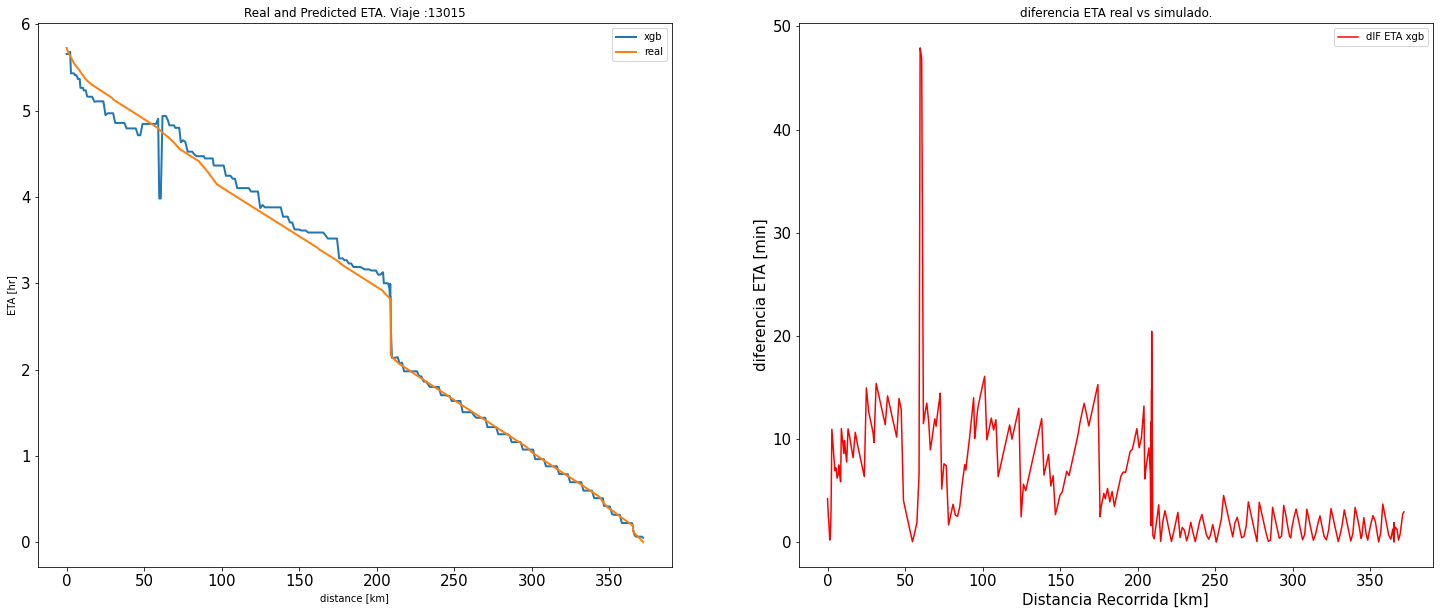

en promedio este algoritmo tiene un error de :  6  minutos


In [73]:
import random


od = 'TO-SA'
test = pd.read_csv(folder+'dynamics-'+od+'-20200101-20210630.csv')

dispatch = random.choice(test.Id.unique().tolist())
aux = test[test['Id']==test.Id.unique().tolist()[-10]]
variables = ['time_s','distance_m','hour','lat','lon']
data_pred = aux.loc[:,variables].values.tolist()
pred_xgb = []
for i in data_pred:
    pred_xgb.append(predict_multimodels(i, od+'.tar.gz'))
plot_eta(aux,pred_xgb,dispatch)

# Lanzar endpoint una vez entrenado

__Si no se cambia el nombre del endpoint levantará el mismo endpoint entrenado previamente__

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.xgboost.estimator import XGBoost
import boto3


sagemaker_session = sagemaker.Session()
role = get_execution_role()

BUCKET = 'migtra.ai.dev'

# This is references the AWS managed XGBoost container
XGBOOST_IMAGE = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='1.0-1')

DATA_PREFIX = 'XGBOOST_ETA'
MULTI_MODEL_ARTIFACTS = 'multi_model_artifacts'

TRAIN_INSTANCE_TYPE = 'ml.m5.2xlarge'
ENDPOINT_INSTANCE_TYPE = 'ml.m4.xlarge'

ENDPOINT_NAME = 'mm-xgboost-eta'

MODEL_NAME = ENDPOINT_NAME

mme = MultiDataModel(name=MODEL_NAME,
                     model_data_prefix=model_data_prefix,
                     image_uri= XGBOOST_IMAGE,
                     role = role,# passing our model - passes container image needed for the endpoint
                     sagemaker_session=sagemaker_session)

predictor = mme.deploy(initial_instance_count=1,
                       instance_type=ENDPOINT_INSTANCE_TYPE,
                       endpoint_name=ENDPOINT_NAME)

list(mme.list_models())